## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [2]:
from TCGame_Env2 import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [3]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [4]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [5]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [6]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
  
def epsilon_greedy(state, time):
    max_epsilon = 1.0
    min_epsilon = 0.001
    epsilon = (min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*time))
  
    z = np.random.random()
    state1 = Q_state(state)
    valid_act = valid_actions(state)
        
    if z > epsilon:
        action = max(Q_dict[state1],key=Q_dict[state1].get)
        p='exploitation'#Exploitation: this gets the action corresponding to max q-value of current state
    else:
        action = random.choice(valid_act)
        p='Exploration'#Exploration: randomly choosing and action
    
    return action



#### Tracking the state-action pairs for checking convergence - write your code here

In [7]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)

States_track = collections.defaultdict(dict)

### states_tracked_1.pkl is compiled and fully loaded with states and action of 10Mn episodes. States_tracked.pkl is for testing the code

In [8]:
# with open('Policy.pkl', 'rb') as handle:
#     Q_dict = pickle.load(handle)
    
# with open('Rewards.pkl', 'rb') as handle:
#     rewards_tracked = pickle.load(handle)    


In [9]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [('x-1-x-4-x-x-x-x-x',(0,3)),('x-x-1-x-x-x-x-4-x',(1,5)),('x-x-5-x-x-x-x-2-x',(1,7)),('x-x-x-x-5-2-x-7-8',(2,9)),('2-6-x-x-x-9-3-x-x',(2,7))]    #select any 4 Q-values
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []

In [10]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [11]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [12]:
initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [14]:
EPISODES = 10000000             
LR = 0.01                  #learning rate
GAMMA = 0.91
threshold = 2000       #every these many episodes, the 4 Q-values will be stored/appended (convergence graphs)
policy_threshold = 32000    #every these many episodes, the Q-dict will be updated

### Q-update loop ---write your code here

In [15]:
start_time = time.time()

for episode in range(EPISODES):
    env=TicTacToe()
    initial_state = env.state    
    curr_state = env.state     

    if episode%20000==1:
        print('Episodes Completed: ',episode-1)
    add_to_dict(curr_state)
    time_step = 0
    reward = None
    total_reward=0
    contin=False
    
    while not contin:
        
        curr_action = epsilon_greedy(curr_state, episode)

        
        next_state, reward, contin = env.step(curr_state, curr_action)
        total_reward += reward
        add_to_dict(next_state)
        
        if contin==False:
        # UPDATE RULE
            max_next = max(Q_dict[Q_state(next_state)],key=Q_dict[Q_state(next_state)].get)   #this gets the action corresponding to max q-value of next state
            Q_dict[Q_state(curr_state)][curr_action] += LR * ((reward + (GAMMA*(Q_dict[Q_state(next_state)][max_next]))) - Q_dict[Q_state(curr_state)][curr_action])
        else:
            Q_dict[Q_state(curr_state)][curr_action] += LR * ((reward - Q_dict[Q_state(curr_state)][curr_action]))
        curr_state = next_state
        
        
    if (episode == threshold-1):        #at the 1999th episode
        initialise_tracking_states()
      
    if ((episode+1) % threshold) == 0:   #every 2000th episode
        save_tracking_states()
        save_obj(States_track,'States_tracked')   
    
    #SAVING POLICY
    if ((episode+1)% policy_threshold ) == 0:  #every 30000th episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy')
           
elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')

print('Elapsed_time: ', elapsed_time)

Episodes Completed:  0
Episodes Completed:  20000
Episodes Completed:  40000
Episodes Completed:  60000
Episodes Completed:  80000
Episodes Completed:  100000
Episodes Completed:  120000
Episodes Completed:  140000
Episodes Completed:  160000
Episodes Completed:  180000
Episodes Completed:  200000
Episodes Completed:  220000
Episodes Completed:  240000
Episodes Completed:  260000
Episodes Completed:  280000
Episodes Completed:  300000
Episodes Completed:  320000
Episodes Completed:  340000
Episodes Completed:  360000
Episodes Completed:  380000
Episodes Completed:  400000
Episodes Completed:  420000
Episodes Completed:  440000
Episodes Completed:  460000
Episodes Completed:  480000
Episodes Completed:  500000
Episodes Completed:  520000
Episodes Completed:  540000
Episodes Completed:  560000
Episodes Completed:  580000
Episodes Completed:  600000
Episodes Completed:  620000
Episodes Completed:  640000
Episodes Completed:  660000
Episodes Completed:  680000
Episodes Completed:  700000
E

Episodes Completed:  5700000
Episodes Completed:  5720000
Episodes Completed:  5740000
Episodes Completed:  5760000
Episodes Completed:  5780000
Episodes Completed:  5800000
Episodes Completed:  5820000
Episodes Completed:  5840000
Episodes Completed:  5860000
Episodes Completed:  5880000
Episodes Completed:  5900000
Episodes Completed:  5920000
Episodes Completed:  5940000
Episodes Completed:  5960000
Episodes Completed:  5980000
Episodes Completed:  6000000
Episodes Completed:  6020000
Episodes Completed:  6040000
Episodes Completed:  6060000
Episodes Completed:  6080000
Episodes Completed:  6100000
Episodes Completed:  6120000
Episodes Completed:  6140000
Episodes Completed:  6160000
Episodes Completed:  6180000
Episodes Completed:  6200000
Episodes Completed:  6220000
Episodes Completed:  6240000
Episodes Completed:  6260000
Episodes Completed:  6280000
Episodes Completed:  6300000
Episodes Completed:  6320000
Episodes Completed:  6340000
Episodes Completed:  6360000
Episodes Compl

#### Check the Q-dictionary

In [16]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -0.8577651356401792,
              (0, 3): -1.3273168085748288,
              (0, 5): -1.0759153920025901,
              (0, 7): -1.351508915443434,
              (0, 9): -1.25358695017404,
              (1, 1): 0.8108191429140781,
              (1, 3): -1.3222596772854998,
              (1, 5): -0.3235168262269633,
              (1, 7): -1.125984904956313,
              (1, 9): -1.3181233810406652,
              (2, 1): -1.3197851555766793,
              (2, 3): -1.332920532690612,
              (2, 5): -1.3826229840995798,
              (2, 7): -1.3504080599633652,
              (2, 9): 5.532360274346585,
              (3, 1): -1.316724851750664,
              (3, 3): -1.248650597729276,
              (3, 5): -1.3316920506485572,
              (3, 7): -1.2294560119531992,
              (3, 9): -1.328794286982842,
              (4, 1): -1.3139251347699334,
              (4, 3): -1.1627789467118819,
              (4, 5): -1.3

In [17]:

len(Q_dict)

2261311

### states_tracked_1.pkl is compiled and fully loaded with states and action of 10Mn episodes. States_tracked.pkl is for testing the code

In [3]:
with open('States_tracked_1.pkl', 'rb') as handle:
    States_track = pickle.load(handle)

In [4]:
for key, value in States_track.items():
    for k,v in value.items():
        print(len(v))


4999
4999
4999
4877
4907


In [5]:

for key, value in States_track.items():
    for k,v in value.items():
        print(key, k)

x-1-x-4-x-x-x-x-x (0, 3)
x-x-1-x-x-x-x-4-x (1, 5)
x-x-5-x-x-x-x-2-x (1, 7)
x-x-x-x-5-2-x-7-8 (2, 9)
2-6-x-x-x-9-3-x-x (2, 7)


#### Check the states tracked for Q-values convergence
(non-evaluative)

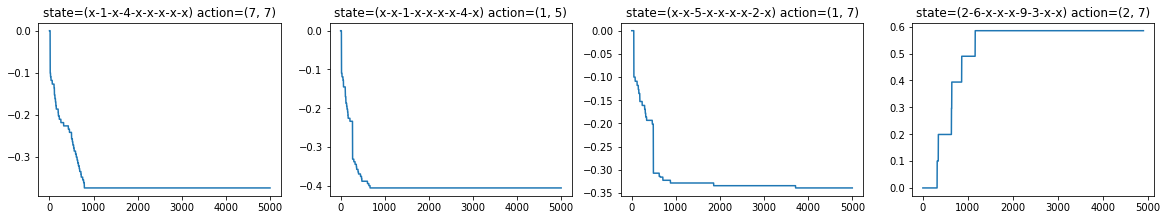

In [6]:
#fiure 1:
xaxis = np.asarray(range(0, len(States_track['x-1-x-4-x-x-x-x-x'][(0, 3)])))
plt.figure(0, figsize=(20,7))
plt.subplot(241)
plt.title('state=(x-1-x-4-x-x-x-x-x) action=(7, 7)')
plt.plot(xaxis,np.asarray(States_track['x-1-x-4-x-x-x-x-x'][(0,3)]))
#Figure 2:
xaxis = np.asarray(range(0, len(States_track['x-x-1-x-x-x-x-4-x'][(1, 5)])))
plt.subplot(242)
plt.title('state=(x-x-1-x-x-x-x-4-x) action=(1, 5)')
plt.plot(xaxis,np.asarray(States_track['x-x-1-x-x-x-x-4-x'][(1, 5)]))
#Figure 3:
xaxis = np.asarray(range(0, len(States_track['x-x-5-x-x-x-x-2-x'][(1, 7)])))
plt.subplot(243)
plt.title('state=(x-x-5-x-x-x-x-2-x) action=(1, 7)')
plt.plot(xaxis ,np.asarray(States_track['x-x-5-x-x-x-x-2-x'][(1, 7)]))
#figure 4:
xaxis = np.asarray(range(0, len(States_track['2-6-x-x-x-9-3-x-x'][(2, 7)])))
plt.subplot(244)
plt.title('state=(2-6-x-x-x-9-3-x-x) action=(2, 7)')
plt.plot(xaxis,np.asarray(States_track['2-6-x-x-x-9-3-x-x'][(2, 7)]))

plt.show()

### Epsilon - decay check

In [177]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

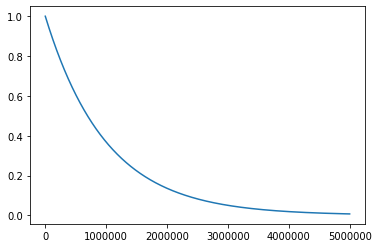

In [178]:
plt.plot(time, epsilon)
plt.show()